In [3]:
# Copyright (C) 2025 fortiss GmbH
# SPDX-License-Identifier:  BSD-3-Clause

import os
import glob
import zipfile
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from gait_snn_dataset import DVSGaitDataset

import sys
sys.path.append("../")
from config import Config  

img_type_dict={
    'time_only_two_channel':{'channel_num':2, 'file': Config.two_channels_time_file},
    'counts_only_two_channel':{'channel_num':2, 'file': Config.two_channels_counts_file},
    'counts_and_time_two_channel':{'channel_num':2, 'file': Config.two_channels_counts_and_time_file},
    'four_channel':{'channel_num':4, 'file': Config.four_channels_file},
}

In [82]:
batch_size = 1
img_type = "four_channel"
print(Config.image_dir)
train_dataset = DVSGaitDataset(os.path.join(Config.image_dir, img_type_dict[img_type]['file']), train=True)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=0, shuffle=True, drop_last=True)

test_dataset = DVSGaitDataset(os.path.join(Config.image_dir, img_type_dict[img_type]['file']), train=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=0, shuffle=True, drop_last=True)

c:\hackathon\2025-nc-hackathon-event-id\../data/DVS128-Gait-DATASET/DVS128-Gait-Day\image


In [91]:
import numpy as np
sample = train_dataset[0]
print(sample[1])
sample = sample[0]
#sample = np.array(sample)
sample.shape

0


(128, 128, 4)

In [112]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# arr shape: (128, 128, 4)
on_counts  = sample[:,:,0]
off_counts = sample[:,:,1]
on_time    = sample[:,:,2]
off_time   = sample[:,:,3]

# Number of animation frames
n_frames = 50

# Create empty movie frames
frames = np.zeros((n_frames, 128, 128))

for i in range(128):
    for j in range(128):
        # ON contribution distributed by ON timestamp
        t_on = on_time[i,j]
        if on_counts[i,j] > 0:
            idx_on = int(t_on * (n_frames - 1))
            frames[idx_on, i, j] += on_counts[i,j]

        # OFF contribution distributed by OFF timestamp
        t_off = off_time[i,j]
        if off_counts[i,j] > 0:
            idx_off = int(t_off * (n_frames - 1))
            frames[idx_off, i, j] -= off_counts[i,j]  # negative for OFF (blue)

MovieWriter imagemagick unavailable; using Pillow instead.


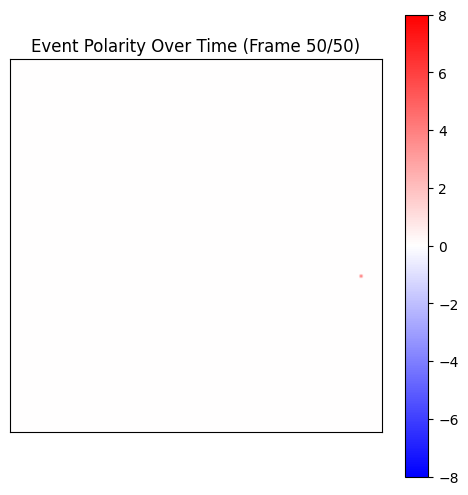

In [115]:
frames = np.swapaxes(frames, 2, 1)

fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(frames[0], cmap='bwr', vmin=-frames.max(), vmax=frames.max())
ax.invert_yaxis()  # Negate y-axis

ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])




ax.set_title("Event Polarity Over Time (Frame 1)")
plt.colorbar(im, ax=ax)

def update(t):
    im.set_data(frames[t])
    ax.set_title(f"Event Polarity Over Time (Frame {t+1}/{n_frames})")
    return [im]

ani = FuncAnimation(fig, update, frames=n_frames, interval=200, blit=False)

ani.save('event_polarity_animation.gif', writer='imagemagick')

plt.show()

Keys: <KeysViewHDF5 ['test (1)_0_1.txt', 'test (1)_0_10.txt', 'test (1)_0_100.txt', 'test (1)_0_11.txt', 'test (1)_0_12.txt', 'test (1)_0_13.txt', 'test (1)_0_14.txt', 'test (1)_0_15.txt', 'test (1)_0_16.txt', 'test (1)_0_17.txt', 'test (1)_0_18.txt', 'test (1)_0_19.txt', 'test (1)_0_2.txt', 'test (1)_0_20.txt', 'test (1)_0_21.txt', 'test (1)_0_22.txt', 'test (1)_0_23.txt', 'test (1)_0_24.txt', 'test (1)_0_25.txt', 'test (1)_0_26.txt', 'test (1)_0_27.txt', 'test (1)_0_28.txt', 'test (1)_0_29.txt', 'test (1)_0_3.txt', 'test (1)_0_30.txt', 'test (1)_0_31.txt', 'test (1)_0_32.txt', 'test (1)_0_33.txt', 'test (1)_0_34.txt', 'test (1)_0_35.txt', 'test (1)_0_36.txt', 'test (1)_0_37.txt', 'test (1)_0_38.txt', 'test (1)_0_39.txt', 'test (1)_0_4.txt', 'test (1)_0_40.txt', 'test (1)_0_41.txt', 'test (1)_0_42.txt', 'test (1)_0_43.txt', 'test (1)_0_44.txt', 'test (1)_0_45.txt', 'test (1)_0_46.txt', 'test (1)_0_47.txt', 'test (1)_0_48.txt', 'test (1)_0_49.txt', 'test (1)_0_5.txt', 'test (1)_0_50.tx

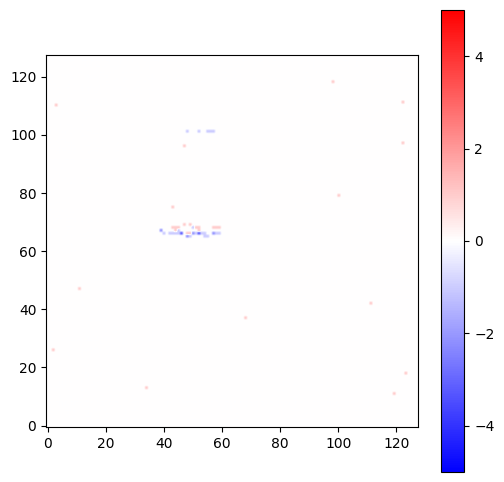

In [126]:
import h5py
import os


with h5py.File(Config.events_file, 'r') as hdf:
    # List all groups
    print("Keys: %s" % hdf.keys())
    # Get the first group
    a_group_key = list(hdf.keys())[1]
    # Get the data
    sample = hdf[a_group_key][:]
    print(np.unique(sample[:,3]))
    print(data.shape)

# Normalize time to [0,1]
t = sample[:,0]
t_norm = (t - t.min()) / (t.max() - t.min())

# Number of animation steps
n_frames = 30

frames = np.zeros((n_frames, 128, 128))

for ti, xi, yi, pi in sample:
    ti_norm = (ti - t.min()) / (t.max() - t.min())
    idx = int(ti_norm * (n_frames - 1))
    frames[idx, int(yi), int(xi)] += 1 if pi > 0 else -1

# Correct x/y orientation
frames = frames.swapaxes(1,2)

fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(frames[0], cmap='bwr', vmin=-frames.max(), vmax=frames.max())
ax.invert_yaxis()
plt.colorbar(im, ax=ax)

def update(step):
    im.set_data(frames[step])
    ax.set_title(f"Time Evolution — Frame {step+1}/{n_frames}")
    return [im]

frames = np.swapaxes(frames, 1, 2)  # (t, y, x) instead of (t, x, y)

ani = FuncAnimation(fig, update, frames=n_frames, interval=200, blit=False)
plt.show()

ani.save("event_polarity_over_time.gif", fps=10)

In [17]:
import h5py
from operator import itemgetter

hdf = h5py.File(Config.events_file, 'r')
train_keys = [key for key in hdf.keys() if "train" in key]
train_person = [int(key.replace("train (1)_","").replace(".txt", "").split("_")[0]) for key in train_keys]
train_num_sample = [int(key.replace("train (1)_","").replace(".txt", "").split("_")[1]) for key in train_keys]
data_train = itemgetter(*train_keys)(hdf)

print(data_train[0][:,0])

[1.84182157e+08 1.84184013e+08 1.84204606e+08 ... 1.88557393e+08
 1.88557996e+08 1.88560405e+08]


In [9]:
from gait_snn_dataset import DVSGaitDataset, rotate, scale, shift, del_outside
import os
import sys
sys.path.append("../")
from config import Config  
import numpy as np

sampling_time = 20_000      # 1 ms per bin (since 1000 µs = 1 ms)
sample_length = 4_000_000 # total length ≈ 4 seconds
transform = scale
dataset_train = DVSGaitDataset(os.path.join(Config.events_file), train=True, random_shift=False, sample_length=sample_length, sampling_time=sampling_time, transform=transform)
events = dataset_train[0][0]
print(np.unique(events[:,:,:,-20]))
events.shape

(50994, 4)
(49285, 4)
[0. 1.]


torch.Size([2, 128, 128, 200])

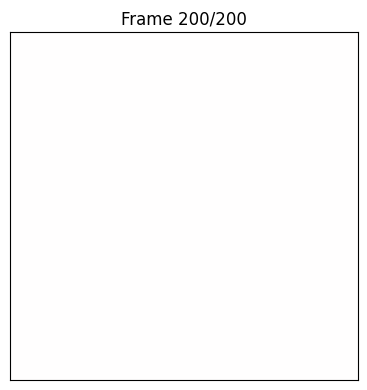

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

# Assume events shape is (2, 128, 128, 100)
# events = np.load("your_data.npy")

# Convert (2, H, W, T) into signed event frames
# ON events (+1), OFF events (-1)
frames = events[0] - events[1]  # shape: (128, 128, 100)
frames = np.swapaxes(frames, 0, 2)  # -> (T, 128, 128)
frame = np.swapaxes(frames, 2, 1)  # -> (T, 128, 128)
# Normalize globally for consistent contrast
vmax = np.abs(frames).max()

# Create the figure
fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(frames[0], cmap='bwr', vmin=-vmax, vmax=vmax)
ax.set_title("Event Polarity Over Time")

ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.invert_yaxis()
plt.tight_layout()

# Define update function for animation
def update(i):
    im.set_data(frames[i].T)
    ax.set_title(f"Frame {i+1}/{frames.shape[0]}")
    return [im]

# Create animation
ani = FuncAnimation(fig, update, frames=frames.shape[0], interval=100, blit=False)

# Save as GIF
writer = PillowWriter(fps=25)
ani.save("event_polarity_over_time.gif", writer=writer)

plt.show()